In [1]:
# Preamble: load packages
import Pkg;

Pkg.add([
    "CairoMakie",
    "VoronoiCells",
    "Images",
    "GeometryBasics",
])
using CairoMakie
using VoronoiCells, GeometryBasics
using Images


   Resolving package versions...


  No Changes to `~/.julia/environments/v1.9/Project.toml`
  No Changes to `~/.julia/environments/v1.9/Manifest.toml`


In [73]:
function area(polygon)
    A = 0.0
    @inbounds for i in eachindex(polygon)
        x1,y1 = polygon[i]
        x2,y2 = polygon[(i + 1) % length(polygon) + 1]

        A += x1 * y2 - x2 * y1
    end

    return A / 2
end

function centroid(polygon)
    A = 0.0
    c_x = 0.0
    c_y = 0.0

    for i in eachindex(polygon) 
        @show polygon[i]
        x1,y1 = polygon[i]
        x2,y2 = polygon[(i+1) % length(polygon) + 1]

        det = x1 * y2 - x2 * y1        
        A += det
        c_x += (x1 + x2) * det
        c_y += (y1 + y2) * det
    end

    return Point2([c_x, c_y] / 12A)
end

centroid (generic function with 1 method)

In [69]:
# Quick voronoi demo

# Bounding box
bbox = Rectangle(Point2(0,0), Point2(1,1))
points = Point2.(eachcol(rand(2, 10)))

10-element Vector{Point2{Float64}}:
 [0.09577944612238709, 0.9559505001061563]
 [0.7820099242673992, 0.47766253993627117]
 [0.8391521481449994, 0.9719709462216094]
 [0.4706786068878763, 0.9705909236902359]
 [0.7237763976821792, 0.8562382911692774]
 [0.6224746803683803, 0.4493794763684037]
 [0.46499735798128705, 0.01309193085887872]
 [0.9280622071093937, 0.3243986700214886]
 [0.3887027684889006, 0.13992561951521965]
 [0.24692160387187845, 0.15667113683510325]

In [91]:
voro_tess = voronoicells(points, bbox)
centroids = centroid(reverse(voro_tess.Cells[1]))

polygon[i] = [0.28179468790950934, 1.0]
polygon[i] = [0.29597045338251327, 0.6369993976938938]
polygon[i] = [0.22881633265966006, 0.5671774898324253]
polygon[i] = [0.0, 0.5239087707390504]
polygon[i] = [0.0, 1.0]


2-element Point2{Float64} with indices SOneTo(2):
 0.042844342253837896
 0.18062684950874072

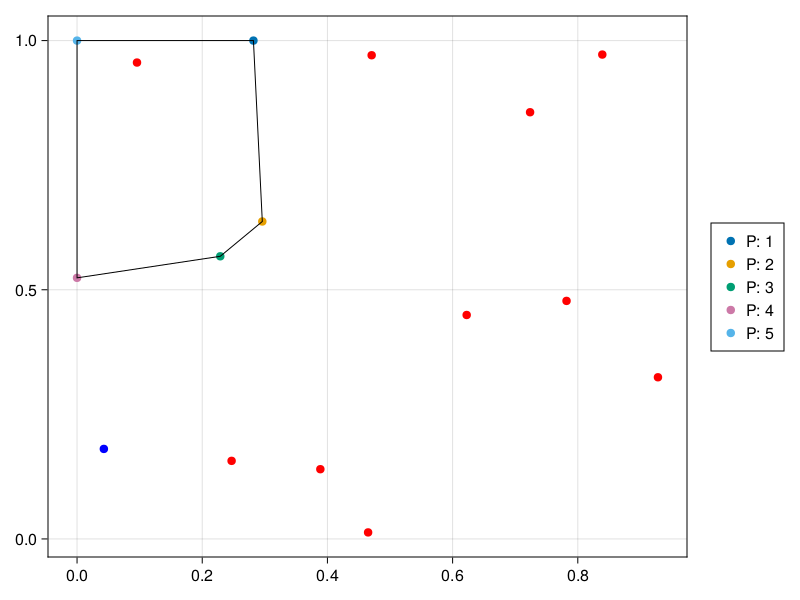

In [93]:
fig,ax,scat_plot = scatter(points, color=:red, label="Point")
cent_plot = scatter!(ax, centroids, color=:blue, label="Center")

polys = Polygon(voro_tess.Cells[1])

p_list = []
for i in 1:length(voro_tess.Cells[1])
    push!(p_list, scatter!(ax, reverse(voro_tess.Cells[1])[i]))
end

poly!(ax, polys, color=:transparent, strokewidth=1)

Legend(fig[1,2], p_list, ["P: $i" for i in 1:length(voro_tess.Cells[1])])
# poly_lines = poly!(Ref(ax), polys, color=:transparent, strokewidth=1, srokecolor=:blue)
# Legend(fig[1,2], [scat_plot, cent_plot, poly_lines[1]], ["Point", "Center", "Voronoi Cell"])
fig